# Homework 1: Missing Data and inverse propensity weighting

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import scipy
import pandas as pd
import numpy as np
from numpy.random import default_rng
import seaborn as sns
from tools import KangSchafSampler, get_estimator_stats
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import GradientBoostingClassifier

## Kang & Schafer Simulated Dataset

The sampling distribution provided in `sampler.py` (KangSchafSampler) was based on Kang and Schafer's [Demystifying Double Robustness: A Comparison of Alternative Strategies for Estimating a Population Mean from Incomplete Data](https://projecteuclid.org/download/pdfview_1/euclid.ss/1207580167) in Section 1.4. They describe the motivation for the simulated dataset in the discussion at the end:

>"We constructed our simulation to vaguely resemble a quasi-experiment to measure the effect of
dieting on body mass index (BMI) in a large sample of high-school students. The study has a pre-post
design. Covariates $x_i$ measured at baseline include
demographic variables, BMI, self-perceived weight
and physical fitness, social acceptance and personality measures. The treatment $t_i$ is dieting (0 = yes, 1 =
no) and the outcome $y_i$ is BMI one year later. The goal
is to estimate an average causal effect of dieting among
those who actually dieted. For that purpose, it suffices
to treat the dieters as nonrespondents, set their BMI
values to missing, and apply a missing-data method
to estimate what the mean BMI for this group would
have been had they not dieted."

In terms of the missing data and response bias problem that we've been studying, Kang and Schafer are interested in the situation where we are not given the propensity scores of our observations, but rather we have to estimate the propensity score function from data using a model.  They consider two cases: 1) The model we're fitting is "correct", in the sense that the true propensity score function is in the parameterized set of functions of our model. In machine learning terminology, we would just say that the hypothesis space has 0 approximation error. 2) The model we're fitting is "incorrect", in the sense that the true propensity score function is not in our model (i.e. there is nonzero approximation error). 

To simulate these two cases, they create a simple data generating distribution where each response $y$ is an affine function of a covariate vector $z$, plus Gaussian noise.  Similarly, the response probability is determined by a logistic regression model on $z$:
* Covariate: $z=(z_1, z_2, z_3, z_4) \sim N(0, I_{4x4})$
* Response: $y = 210 + 27.4z_1 + 13.7z_2 + 13.7z_3 + 13.7z_4 + \epsilon$ where $\epsilon \sim N(0,1)$
* Propensity: $\pi = expit(-z_1 + 0.5z_2 - 0.25z_3 - 0.1z_4)$ which is called `obs_prob` in code below
* $r = Bernoull(\pi)$ is the response indicator, which is called `obs` in code below

Using logistic regression on $z$ would be a "correct" model in this case. To simulate an "incorrect" model, they introduce a new covariate $x=(x_1, x_2, x_3, x_4)$, which is a complicated nonlinear transform of $z$.  (See `transform_z` from `KangSchafSampler.get_x` in tools.py for the explicit mapping -- although in "real life" you would not know this transform function.) They then investigate using logistic regression on $x$ to model the propensity score function.  This is clearly an "incorrect" model, since logistic regression has a linear dependence on $x$, while the true model has a nonlinear dependence on $x$.

In the notebook below, we'll compare using incorrect and correct models in this setting, and we'll also see if we can improve the situation by using modern nonlinear ML models for the propensity function based on $x$.

For our sampling distribution:
* Overall mean of y = 210
* Mean of observed y = 200 
* Mean of missing y = 220
* Response rate = 0.5

Our goal below is to use the observed data to estimate the overall mean of y.  We'll evaluate performance using RMSE between our estimates and 210, which we know to be the actual overall mean.  

To start our investigation, we'll visualize the distribution of each component of $x$ for the complete and incomplete cases (corresponding to `obs=True` and `obs=False`.

In [3]:
sampler = KangSchafSampler(rng=default_rng(27))
s = sampler.sample(n=200)
s.head() 

,z1,z2,z3,z4,x1,x2,x3,x4,obs_prob,obs,y
0,1.254448,0.776902,0.964881,-1.082178,1.872406,10.172419,0.272622,387.882139,0.269138,True,252.441072
1,0.867017,-0.168161,-0.189661,1.120566,1.542661,9.950245,0.208974,439.003304,0.265858,True,244.895501
2,-0.436779,-1.279645,-0.469500,-1.196827,0.803812,9.222627,0.224981,307.074015,0.508503,False,156.990005
3,-1.839857,-0.145557,0.398279,-2.162061,0.398548,9.874394,0.185865,313.020372,0.868037,False,133.941012
4,0.014477,0.255198,0.173191,-1.270094,1.007265,10.126675,0.216108,360.434196,0.549050,False,197.966340


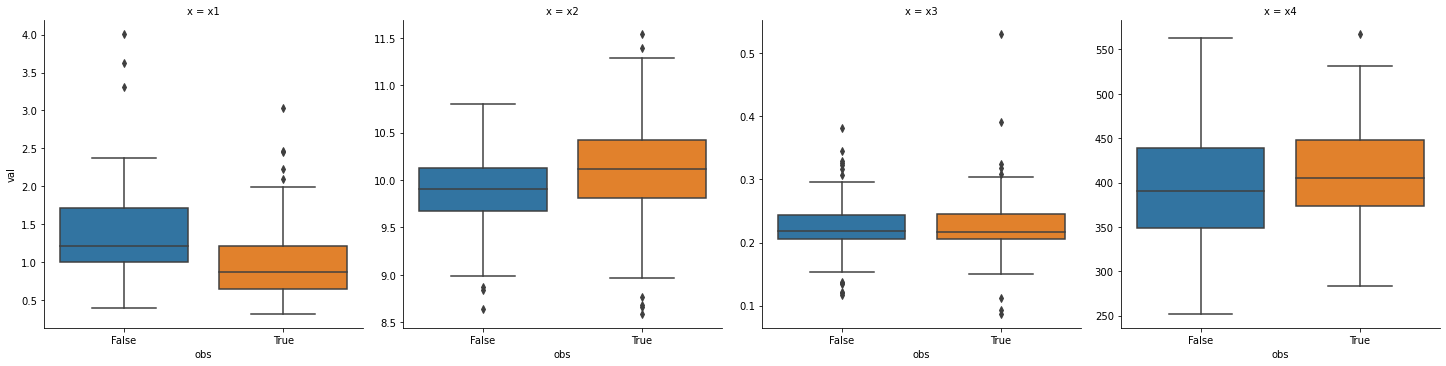

In [4]:
df_long = pd.melt(s[['x1', 'x2', 'x3', 'x4', 'obs']], "obs", var_name="x", value_name="val")
g = sns.catplot(x="obs", y="val", col="x", data=df_long, kind="box", sharey=False)

From the box plot, we can see from the $x_1$ plot, in particular, that values are not missing completely at random.  This justifies the additional complexity of using estimators for the MAR setting, rather than just a complete-case estimator.

### Problem 1

**PART A:** Create a function that calculates the IPW and self-normalized IPW mean estimators from a sample. Additionally, include a total of the weights associated to *observed* outcomes. We will use this function below. 

In [5]:
np.mean(s.obs_prob.astype(float)*s.y/s.obs_prob)

212.3640228092415

In [6]:
def ipw_estimators(obs_prob, obs, outcome):
    """
    
    Args:
        obs_prob (pd.Series): probabilities that y_i were observed (i.e. propensities)
        obs (pd.Series): boolean series that tells whether value was observed or not
        outcome (pd.Series): the measurement of the outcome y_i
    
    Returns:
        dict: {'ipw': ipw, 'sn_ipw': sn_ipw, 'total_weight': total_weight}
    """
    ipw = np.mean(obs.astype(float) * outcome / obs_prob)
    sn_ipw = np.sum(obs.astype(float) * outcome / obs_prob) / np.sum(obs.astype(float) / obs_prob)
    total_weight = np.sum(obs.astype(float) / obs_prob)
    
    return {'ipw': ipw, 'sn_ipw': sn_ipw, 'total_weight': total_weight}

**PART B:** Run 1000 trials of the following: 1) Draw a sample `sample_size=200` from the sampler defined above. 2) Get the ipw and sn_ipw estimates of the overall mean using the `ipw_estimators()` function you created above.  For this simulation, use the true propensities for each observation, which are given in the `obs_prob` column of the dataframe returned by the sampler. Collect all these results into a dataframe. So that we can use the `get_estimator_stats` function below, each row of the resulting dataframe should correspond to a single trial and each column should correspond to an estimator (either ipw or sn_ipw).

In [7]:
data = []
total_weights = []
for i in range(1000):
    s = sampler.sample(n=200)
    d = ipw_estimators(s.obs_prob, s.obs, s.y)
    data.append((d["ipw"], d["sn_ipw"]))
    total_weights.append(d["total_weight"])
estimates = pd.DataFrame.from_records(data, columns=["ipw", "sn_ipw"])

**PART C:** Compute the bias, variance, and RMSE of the IPW and the self-normalized IPW estimators using `get_estimator_stats` from tools.py (already imported). Briefly summarize your findings.

In [8]:
get_estimator_stats(estimates, true_mean=210)

,stat,mean,SD,SE,bias,RMSE
0,ipw,209.404779,24.185898,0.764825,-0.595221,24.193221
1,sn_ipw,209.597428,4.841999,0.153117,-0.402572,4.858705


**PART D:** Show that for the ipw estimator, the estimates of SD, bias, and RMSE are compatible in terms of the bias-variance decomposition identity.

We can see that ipw has higher variance than sn_ipw and its error is dominated by the high variance. Also, we can see that for ipw it is true that $\text{RMSE}^2 \approx \text{SD}^2 + \text{bias}^2.$

### Problem 2

**PART A:** Graph the scatterplot of the IPW estimate vs total_weight across trials recorded in the results dataframe from Problem 1. *Do the same* for the self-normalized IPW estimate.  Report the correlation for each. Briefly describe your findings.

In [9]:
estimates["total_weight"] = total_weights

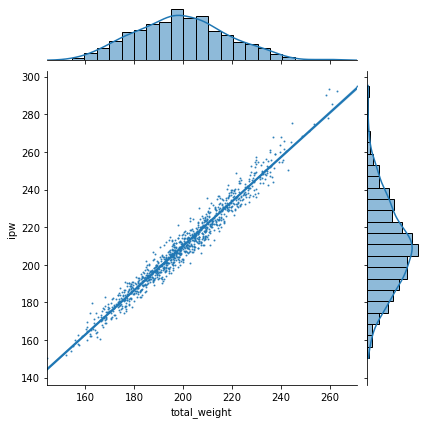

In [51]:
sns.jointplot(data=estimates, x='total_weight', y='ipw', kind="reg", x_jitter=0, scatter_kws={"s": 1})

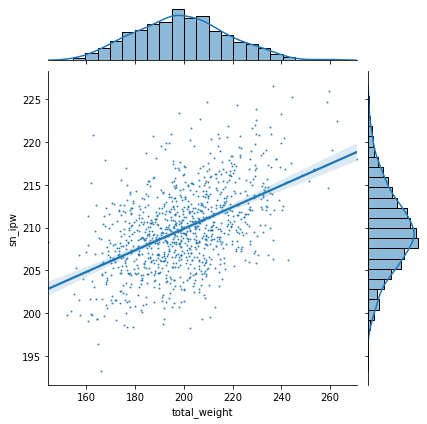

In [52]:
sns.jointplot(data=estimates, x='total_weight', y='sn_ipw', kind="reg", x_jitter=0, scatter_kws={"s": 1})

In [10]:
estimates['total_weight'].corr(estimates['ipw'])

0.9841330700208994

In [11]:
estimates['total_weight'].corr(estimates['sn_ipw'])

0.5033241371884397

Correlation for ipw and sn_ipw are $0.98$ and $0.5$ respectively. We can see that sn_ipw suffers less from the effects of having different amount of observations. Its estimate is not affected by that.

### Problem 3

In the previous problems, we used the true propensities that our dataset generator provided us in the (`obs_prob`) column. In this problem, we'll investigate the impact of estimating the propensity score function from data, both for a "correct" model and an "incorrect" model.  

**PART A:** Following the pattern in Problems 1.B and 1.C above, compare the performance of the IPW estimator using the true propensities to the performance using propensities predicted by a logistic regression model fit to the $z_i$'s. Also compare to a logistic regression model fit to the $x_i$'s.  Repeat the comparison for the self-normalized IPW estimator. Summarize your findings. [Hint: Figuring out a good naming convention for these estimators is no joke.  We like to use ipw_t for IPW using the true propensities, ipw_lr_x for IPW using a logistic regression estimate of propensity with the $x_i$ covariates.  Then sn_ipw_rf_z when we're using self-normalized IPW with a random forest propensity model based on covariate $z$.]

In [98]:
from tqdm import tqdm

data = []
for i in tqdm(range(1000)):
    s = sampler.sample(n=200)
    model_Z = LogisticRegression(penalty="none", max_iter=500)
    model_X = LogisticRegression(penalty="none", max_iter=500)
    Z = s[["z1","z2","z3","z4"]]
    X = s[["x1","x2","x3","x4"]]
    y = s.obs.astype(int)
    model_Z.fit(Z, y)
    model_X.fit(X, y)
    s["obs_prob_Z"] = model_Z.predict_proba(Z)[:, 1]
    s["obs_prob_X"] = model_X.predict_proba(X)[:, 1]
    d_ipw_true = ipw_estimators(s.obs_prob, s.obs, s.y)
    d_ipw_z = ipw_estimators(s.obs_prob_Z, s.obs, s.y)
    d_ipw_x = ipw_estimators(s.obs_prob_X, s.obs, s.y)
    data.append((d_ipw_true["ipw"], d_ipw_true["sn_ipw"],\
                 d_ipw_z["ipw"], d_ipw_z["sn_ipw"], \
                 d_ipw_x["ipw"], d_ipw_x["sn_ipw"]))
    

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:21<00:00, 46.68it/s]


In [99]:
estimates = pd.DataFrame.from_records(data, columns=["ipw_t", "sn_ipw_t", "ipw_lr_z", "sn_ipw_lr_z", "ipw_lr_x", "sn_ipw_lr_x"])

In [100]:
get_estimator_stats(estimates, true_mean=210)

,stat,mean,SD,SE,bias,RMSE
0,ipw_t,209.565876,23.427887,0.740855,-0.434124,23.431909
1,sn_ipw_t,209.568100,4.729840,0.149571,-0.431900,4.749519
2,ipw_lr_z,209.581466,12.461834,0.394078,-0.418534,12.468860
3,sn_ipw_lr_z,209.760391,3.902717,0.123415,-0.239609,3.910066
4,ipw_lr_x,228.617228,88.299065,2.792262,18.617228,90.240379
5,sn_ipw_lr_x,211.381158,8.096871,0.256046,1.381158,8.213825


From the above result, we can confirm that in the logistics regression case, $x$ is a worse choice than $z$, because we know that logistics regression cannot capture the nonlinear dependence on $x$. Also, sn_ipw performs better than ipw as expected.

**PART B:** In this part we're going to try to get better performance using only the $x_i$'s for our propensity model.  Try using a nonlinear model (e.g. random forest, gradient boosted trees, etc...) to fit the propensity score function. Compare results using IPW and SN_IPW with both logistic regression and your nonlinear model for the propensity score function.  Summarize your findings.

In [95]:
from tqdm import tqdm

data = []
for i in tqdm(range(1000)):
    s = sampler.sample(n=200)
    model_X = LogisticRegression(penalty="none", max_iter=500)
    model_nonlinear = RandomForestClassifier()
    X = s[["x1","x2","x3","x4"]]
    y = s.obs.astype(int)
    model_X.fit(X, y)
    model_nonlinear.fit(X, y)
    s["obs_prob_X"] = model_X.predict_proba(X)[:, 1]
    s["obs_prob_X_nonlinear"] = model_nonlinear.predict_proba(X)[:, 1]
    d_ipw_true = ipw_estimators(s.obs_prob, s.obs, s.y)
    d_ipw_x = ipw_estimators(s.obs_prob_X, s.obs, s.y)
    d_ipw_x_nonlinear = ipw_estimators(s.obs_prob_X_nonlinear, s.obs, s.y)
    data.append((d_ipw_true["ipw"], d_ipw_true["sn_ipw"],\
                 d_ipw_x_nonlinear["ipw"], d_ipw_x_nonlinear["sn_ipw"], \
                 d_ipw_x["ipw"], d_ipw_x["sn_ipw"]))
    

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:56<00:00,  8.60it/s]


In [96]:
estimates = pd.DataFrame.from_records(data, columns=["ipw_t", "sn_ipw_t", "ipw_rf_x", "sn_ipw_rf_x", "ipw_lr_x", "sn_ipw_lr_x"])

In [97]:
get_estimator_stats(estimates, true_mean=210)

,stat,mean,SD,SE,bias,RMSE
0,ipw_t,209.070571,22.630812,0.715649,-0.929429,22.649890
1,sn_ipw_t,209.804915,5.074324,0.160464,-0.195085,5.078072
2,ipw_rf_x,120.622992,7.004204,0.221492,-89.377008,89.651037
3,sn_ipw_rf_x,201.241274,3.445104,0.108944,-8.758726,9.411908
4,ipw_lr_x,231.600021,106.800175,3.377318,21.600021,108.962555
5,sn_ipw_lr_x,211.989101,9.281065,0.293493,1.989101,9.491822


Surprisingly using non-linear models actually give out worse performance than logsitic regression.